Group number: 4
Group memebers:
- Mohamed Al-Obaidi                 
    student number: 
- Florian Peters                    
    student number: 
- Irene Santos Mayo                 
    student number: 212806
- Ananya Rout                      
     student number: 213366

In [12]:
# Importing different libraries
import numpy as np
import scipy.sparse as sps
from scipy.sparse.linalg import eigs
from scipy.sparse import diags
import matplotlib.pyplot as plt
import time

import ipywidgets as widgets
from IPython.display import display
from matplotlib import cm

## Guided modes in 1 + 1D system 

### Subtask 1: Calculate the effective permitivity and field distribution of the guided eigenmodes in TE-polarization and for PEC boundary conditions

This task involves numerically solving the Helmholtz equation for TE-polarized guided modes in a 1D slab waveguide using a second-order finite-difference (FD) method. 
The goal is to compute the effective permittivities and the corresponding electric field distributions of the guided modes.
We start with the Helmholtz equation in 1D for a TE-polarized wave:

We solve the 1D Helmholtz equation:
$$
\left( \frac{d^2}{dx^2} + k_0^2 \, \varepsilon(x) \right) E_0(x) = k_0^2 \, \varepsilon_{\text{eff}} \, E_0(x)
$$

for a TE‐polarized slab (with PEC boundaries at the ends). Discretizing on a uniform grid \(x_j\), \(j=1,\dots,N\), with spacing \(h\), the second derivative becomes

$$
\frac{E_{j+1} - 2\,E_{j} + E_{j-1}}{h^2}
\;+\; k_0^2\,\varepsilon_j\,E_j
\;=\; k_0^2\,\varepsilon_{\mathrm{eff}}\,E_j\,.
$$
We discretize this into an eigenvalue problem:
$$
A E = \varepsilon_{\text{eff}} E
$$
Where A is a tridiagonal matrix with:

- **Main‐diagonal:**

  $$
  A_{j,j} \;=\; -\frac{2}{h^2} \;+\; k_0^2\,\varepsilon_j.
  $$

- **First off‐diagonals:**

  $$
  A_{j,j\pm 1} \;=\; \frac{1}{h^2}.
  $$

(Everything else is zero.)



In [7]:

def guided_modes_1DTE(prm, k0, h):
    """Computes the effective permittivity of a TE polarized guided eigenmode.
    All dimensions are in µm.
    Note that modes are filtered to match the requirement that
    their effective permittivity is larger than the substrate (cladding).
    
    Parameters
    ----------
    prm : 1d-array
        Dielectric permittivity in the x-direction
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated modes
    guided : 2d-array
        Field distributions of the guided eigenmodes
    """
    
    # Matrix Building and solving eigenvalue problem
    # Main and off diagonals for Helmholtz operator: A E = ε_eff E

    main_diag = (-2 / h**2) + (k0**2) * prm
    off_diag = np.ones(number_points - 1) / h**2

    # Sparse tridiagonal matrix (finite difference)
    A = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1], format='csr')

    #Solve eigenvalue problem 
    num_modes = 100
    eigvals, eigvecs = eigs(A, k=num_modes, which='LR')  # LR = Largest Real part

    # Process eigenvalues: ε_eff = eigval / k0^2
    eigvals = np.real(eigvals)
    eff_eps = eigvals / k0**2

    
    # Sorting and filtering guided modes: ε_eff > ε_substrate
    sorted_idx = np.argsort(eff_eps)[::-1] #returns an array of indices that would sort eff_eps in ascending order.
    eff_eps = eff_eps[sorted_idx]#Re‐orders the eff_eps array so that it’s now in descending order
    eigvecs = np.real(eigvecs[:, sorted_idx])# re‐orders those columns in the same descending‐ε_eff order.
    guided_mask = eff_eps > e_substrate 
    eff_eps = eff_eps[guided_mask]
    guided_modes = eigvecs[:, guided_mask]

    return eff_eps, guided_modes

Effective Permittivities (ε_eff) of Guided Modes:
Mode 1: ε_eff = 2.264012
Mode 2: ε_eff = 2.262090
Mode 3: ε_eff = 2.260277
Mode 4: ε_eff = 2.258576
Mode 5: ε_eff = 2.256992
Mode 6: ε_eff = 2.255532
Mode 7: ε_eff = 2.254203
Mode 8: ε_eff = 2.253014
Mode 9: ε_eff = 2.251978
Mode 10: ε_eff = 2.251113
Mode 11: ε_eff = 2.250450
Mode 12: ε_eff = 2.250045


C:\Users\Irene\AppData\Local\Temp\ipykernel_2376\1240694046.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  guided_modes[:, i] /= np.sqrt(np.trapz(np.abs(guided_modes[:, i])**2, xx))


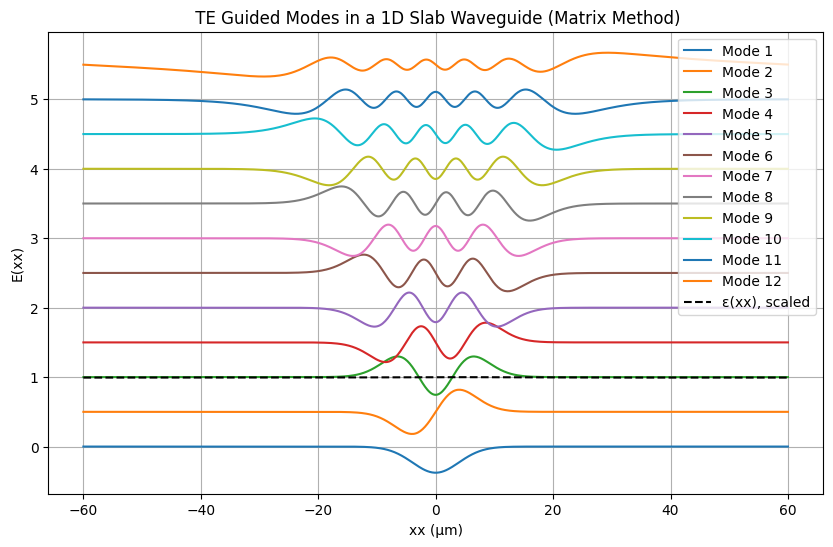

In [8]:
#1D Parameters
grid_size     = 120         # µm
number_points = 601
h             = grid_size/(number_points - 1)# spatial step size
lam           = 0.78        # µm (wavelength)
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0        # width of Gaussian core
xx            = np.linspace( -grid_size/2, grid_size/2, number_points )# Coordinate grid
prm         = e_substrate + delta_e * np.exp(-(xx/w)**2) # Permittivity profile (Gaussian core)


eff_eps, guided_modes = guided_modes_1DTE(prm, k0, h)
# Normalizing each mode
for i in range(guided_modes.shape[1]):
    guided_modes[:, i] /= np.sqrt(np.trapz(np.abs(guided_modes[:, i])**2, xx))

# Output results
print("Effective Permittivities (ε_eff) of Guided Modes:")
for i, eps in enumerate(eff_eps):
    print(f"Mode {i+1}: ε_eff = {eps:.6f}")

# Plotting Field profile of guided modes
plt.figure(figsize=(10, 6))
for i in range(guided_modes.shape[1]):
    plt.plot(xx, guided_modes[:, i] + i*0.5, label=f"Mode {i+1}")

plt.plot(xx, prm/np.max(prm), 'k--', label='ε(xx), scaled')
plt.title(" TE Guided Modes in a 1D Slab Waveguide (Matrix Method)")
plt.xlabel("xx (µm)")
plt.ylabel("E(xx)")
plt.grid(True)
plt.legend()
plt.show()


### Subtask 2: Show and discuss the dependence of your numerical solution on the discretization size h! 

Plotting:
The plot displays both the error $\Delta\epsilon$ between the calculated effective permittivity and the benchmark value of the fundamental mode, as well as the computation time required for each simulation, as functions of the spatial resolution. As the spatial resolution increases (i.e., as the grid becomes finer), the computation time rises nearly linearly on a logarithmic scale, reflecting the greater computational effort needed for finer discretization. Simultaneously, the error $\Delta\epsilon$ decreases rapidly and approaches zero, indicating convergence of the numerical solution toward the benchmark value. This demonstrates the trade-off between computational cost and numerical accuracy when choosing the spatial resolution.

Since the exact or analytical solutions of the differential equation are not known, we must define a measure for the accuracy of our computed numerical solution. To do this, we calculate a highly accurate reference solution using a very fine spatial discretization (i.e., a large value for the number_points variable). The effective permittivity $\epsilon_{eff}$ of the fundamental ($0^{th}$-order) mode from this high-resolution calculation is taken as the benchmark or reference value. By comparing the computed $\epsilon_{eff}$ for different, coarser spatial resolutions to this reference, we can quantitatively assess the convergence and accuracy of our numerical method. Furthermore, we measure the computation time required for each numerical solution. This allows us to identify an optimal spatial resolution that achieves sufficient accuracy without unnecessary expenditure of computational time and resources.



In [11]:
#1D Example Parameters --> very high resolution for reference
grid_size     = 120
number_points = 6000
h = grid_size / (number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace( -grid_size/2, grid_size/2, number_points)
prm           = e_substrate + delta_e * np.exp(-(xx/w)**2)

# Calculate the effective permittivity for the high-resolution case
e_eff, guided = guided_modes_1DTE(prm, k0, h)
e_eff_ref = e_eff[0]


# Performance Analysis
number_points_arr = np.logspace(1,3.5, num=21, dtype=int) #define the number points/ spatial resolutions to test
time_results = [] # List to store computation times
e_eff_results = [] # List to store effective permittivity results
spatial_resolutions = [] # List to store spatial resolutions
for num in number_points_arr:
    # For each number of points, compute the effective permittivity
    # define the parameters that depend on the number of points
    h = grid_size / (num - 1)
    spatial_resolutions.append(h) #store the spatial resolution
    xx = np.linspace( -grid_size/2, grid_size/2, num)
    prm = e_substrate + delta_e * np.exp(-(xx/w)**2)
    start_time = time.time() # start the timer
    e_eff, guided = guided_modes_1DTE(prm, k0, h) # calculate the effective permittivity/ guided modes
    end_time = time.time() # end the timer
    time_results.append(end_time - start_time) #store the time taken for this calculation
    e_eff_results.append(e_eff[0]) #store the effective permittivity of the first mode

error = np.abs(e_eff_results - e_eff_ref) # Calculate the error compared to the benchmark value


ValueError: Diagonal length (index 1: 10 at offset 0) does not agree with array size (6000, 6000).

In [ ]:
# Plotting the results for the 1D example
plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

# First y-axis: Permittivity Profile
ax1.plot(xx, prm, label='Permittivity Profile', color='black')
ax1.set_ylabel('Permittivity', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlabel('Position (µm)')

# Second y-axis: Mode 1
ax2.plot(xx, np.real(guided[:, 1]), label='Mode 1', color='blue')
#ax2.plot(xx, np.real(guided[:, 1]), label='Mode 2', color='blue')
ax2.set_ylabel('Field', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Permittivity Profile and Mode 1 Field')
plt.show()

Plotting:
The plot displays both the error $\Delta\epsilon$ between the calculated effective permittivity and the benchmark value of the fundamental mode, as well as the computation time required for each simulation, as functions of the spatial resolution. As the spatial resolution increases (i.e., as the grid becomes finer), the computation time rises nearly linearly on a logarithmic scale, reflecting the greater computational effort needed for finer discretization. Simultaneously, the error $\Delta\epsilon$ decreases rapidly and approaches zero, indicating convergence of the numerical solution toward the benchmark value. This demonstrates the trade-off between computational cost and numerical accuracy when choosing the spatial resolution.

In [ ]:
# Plotting computation time and error on the same plot with two y-axes
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot error (left y-axis)
ax1.plot(spatial_resolutions, error, marker='x', color='tab:red', label='Effective Permittivity')
ax1.scatter(8000, 0, color='black', label='Reference Value', zorder=5, marker="x")
ax1.axhline(0, color='black', linestyle='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([10**(-1.5), 10**(1.5)])  # Set x-axis limits for better visibility
ax1.set_ylim([1e-9, 1e-1])  # Set y-axis limits for better visibility
ax1.set_xlabel('Spartial Resolution [a.u.]')
ax1.set_ylabel(r'Error $\Delta\epsilon$', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
#ax1.legend(loc='lower right')

# Plot computation time (right y-axis)
ax2.plot(spatial_resolutions, time_results, marker='o', color='tab:blue', label='Computation Time')
ax2.set_yscale('log')
ax2.set_ylabel('Computation Time (seconds)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.legend(loc='lower right')

plt.title('Computation Time and Error vs Number of Points for Guided Modes')
plt.show()

## Guided modes in 2+ 1 2D system (strip waveguide)

### Subtask 1: Calculate the effective permitivity and field distribution of the guided eigenmodes in TE-polarization and for PEC boundary conditions

In [ ]:
#2D Example Parameters
grid_size     = 120
number_points = 301
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace(-grid_size/2-h,grid_size/(2+h),number_points+2)
yy            = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY         = np.meshgrid(xx,yy)
prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)


To observe how different modes propagate within a strip waveguide, one can begin by solving the Helmholtz equation and analyzing the spatial distribution of the wavefunction. In this markdown, we provide an overview of the mathematical steps involved, along with code analogies used to solve the exercise.

During this exercice we have done two assuptions: the first one that there is no z-dependence of the traveling modes and that there is weak guiding, this is
what allows us to use the helmholz equation as the starting point of our approach.

$$
\nabla^2 v(r) + k^2(r, \omega) v(r) = 0 
$$
with
$$
k^2(r,w) = \omega^2/c^2
\epsilon(r,w)
$$

As a first order differential equation one can make the following antsatz that the stationary modes should take:
$$
v(r) = u(x,y)exp(i\beta z)
$$

If one plugs this into the helmholz equation we obtain the following equation, which then is an eigenvalue problem that one can solve and obtain the standing modes that can propagate in the waveguide:
$$
[\frac{\partial^2 }{\partial x^2}+ \frac{\partial^2}{\partial y^2}] u(x,y) + [k^2(x,y, \omega)-\beta ^2(w)]u(x,y)  = 0
$$

As computers cannot work directly with the differential equations, one has to discretice the space in both the x and y direction. Using the finite different method, which then would simplify the above equation into the following:

$$
[\frac{\partial^2 }{\partial x^2}+ \frac{\partial^2}{\partial y^2}] =
\frac{f(x_{j+1},y_k)+f(x_{j-1},y_k)+f(x_{j},y_{k+1})+f(x_j,y_{k-1}) - 4f(x_j,y_{k}) }{h^2}
$$

$$
[\frac{\partial^2 }{\partial x^2}+ \frac{\partial^2}{\partial y^2}] u(x,y) + [k^2(x,y,\omega)-\beta ^2(w)]u(x,y)  = 0
$$

As this is an eigenvalue problem one can rewrite the equation to the following way and this is the start point from which we can take the mathematical implementation:
$$
1/k_0^2[[\frac{\partial^2 }{\partial x^2}+ \frac{\partial^2}{\partial y^2}] u(x,y) + k_{0}^2 \epsilon(x,y,\omega)u(x,y) ] = \epsilon _{eff} u(x,y)
$$
with
$$
k_{0}^2= \frac{w^2 }{c^2}
$$
and with the dispersion relation:
$$
k^2(x,y,\omega)= k_{0}^2\epsilon(x,y,\omega)
$$
and the effective epsilons are then defined as
$$
\epsilon _{eff} = \frac{\beta^2}{k_{0}^2}
$$


As shown above, the differential equation is approximated with a finite difference model, this means that the elements depends on its previous and the fordward,the upward, the downward points when dealing with a 2D domain. A good way to code this is simlpy using a matrix, and because we are solving an eigenvalue problem, solving the eigenvalues of this matrix would give us the solutions we are looking for the effective epsilons.


The fist line in our matrix is the main diagonal, in this case, is when the element gets multiply by itself which in code and math is the following:

math:
$$
- 4\frac{f(x_j,y_{k})}{h^2} + k_{0}^2 \epsilon(x,y,\omega)
$$
Wich in code then can be rewriten as:
 -4.0 *1/(h**2) + k0 ** 2 * np.array(prm_flat)
with np.array(prm_flat) being the epsilons which in our case is a gaussian function 

For the other diagonals are positioned next to this main element, and in the position in which we are jumping into a new row. This means the diagonals corresponding to the adjancent points need to be the upper and lower diagonal to this main diagonal and the ones corresponding to the y positon are where the new row is starting.

As all of them have the same values one can code a simple initialization line and then positon it in the different diagonals.
math:
$$
\frac{f(x_{j+1},y_k)}{h^2}   > diagonal position 1 
$$
$$
\frac{f(x_{j-1},y_k)}{h^2}      > diagonal position -1 
$$
$$
\frac{f(x_{j},y_{k+1})}{h^2}     > diagonal position: nrows 
$$
$$
\frac{f(x_{j},y_{k-1})}{h^2}      > diagonal position: -nrows
$$


Wich in code then can be rewriten as:
np.ones(n)*1/(h**2) 
with n being 
$$
nrows*ncols
$$
To code the positions one can use the follwing  and scipy.sparse.spdiags  which leads to the follwing lines:

data = np.array([diagonal_main, diagonal_sides, diagonal_sides, diagonal_sides,  diagonal_sides]) # collect all diagonals into one requested with the function that we are going to use

diags = np.array([0,-1,1,-nrows, nrows]) # position of diagonals

matrix =sps.spdiags(data, diags, n, n).tocsc() * (1/k0**2) 

As we mentioned this is a eigenvalue problem and we can use the following coding function scipy.sparse.spdiags to get the eigenvalues and eigenvectors which fullfill our helmholz equation which then in code is translated to:
eigenvalues, eigenvectors = eigs(matrix, numb)

as we can obtain a large amount of eigenvalues to reduce the amount of eigenvalues provided the user can define a maximun of eigenvalues with the variable numb.

All the eigenvalues obtained are not physical this is, they are either smaller than the cladding or the maxima of the distribution of the refractive index of our media. Therefore, one has to just select the phsysical solutions of the code with the following lines:

values_interest = (eigenvalues > e_substrate) & (eigenvalues < np.max(prm))  

eff_eps = eigenvalues[values_interest]

guided = eigenvectors[:, values_interest] 

As we are requested to return a 3D array one can rewtite it as follows:
guided = guided.reshape((nrows, ncols, -1), order='F') 






In [16]:
def guided_modes_2D(prm, k0, h, numb):
    """Computes the effective permittivity of a quasi-TE polarized guided 
    eigenmode. All dimensions are in µm.
    
    Parameters
    ----------
    prm  : 2d-array
        Dielectric permittivity in the xy-plane
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    numb : int
        Number of eigenmodes to be calculated
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated eigenmodes
    guided : 3d-array
        Field distributions of the guided eigenmodes
    """
    ###
    # First: Flatted the 2D array into a column, this is becuase to obtain the different eigenvalues
    # the objective would be multiplying this column with the general matrix to obtain the
    # different eigenvalues thus we use the flatten command in numpy
    ###
    prm_flat = prm.flatten(order='F')

    ## 
    # Get the number of columns and row and the total number as we have to create arrays based on that shape
    ##
    nrows, ncols = prm.shape
    n = nrows*ncols

    ##
    # Creation of the two different diagonals: 
    # The main diagonal similar to what we have before 
    # The side diagonals which would go in the positons adjacnet to the points in the x direction and the 
    # new rows in the y diretion still adjacted to the square of interest
    ##
    diagonal_main = -4.0 *1/(h**2) + k0 ** 2 * np.array(prm_flat)  # values of the main diagonal
    diagonal_sides = np.ones(n)*1/(h**2) # values of the other diagonals
    data = np.array([diagonal_main, diagonal_sides, diagonal_sides, diagonal_sides,  diagonal_sides]) # data containing information diagonals
    diags = np.array([0,-1,1,-nrows, nrows]) # position of diagonals
    matrix =sps.spdiags(data, diags, n, n).tocsc() * (1/k0**2)  # creation of matrix

    ##
    # Once the matrix is generated we obtain the eigenvalues and obtain only the physical ones
    ##
    eigenvalues, eigenvectors = eigs(matrix, numb, which='LR') # get the eigenvalues
    values_interest = (eigenvalues > e_substrate) & (eigenvalues < np.max(prm)) # limitation of the physical eigenvalues
    eff_eps = eigenvalues[values_interest] # Physical eigenvalues
    guided = eigenvectors[:, values_interest] # obtain the fields corresponding to those eigenvalues
    guided = guided.reshape((nrows, ncols, -1), order = "F") # reshape the array to obtain a 3D array
    return eff_eps, guided

Plot the different TEM modes that we have calculated, as one can see the solutions that we obtain are similar to the ones one can find in a textbook.

In [ ]:
eff_eps, guided = guided_modes_2D(prm, k0, h, 40)

# Filtion to plot the different eigenfields
def plot_mode(mode_num):
    plt.figure(figsize=(6,5))
    plt.imshow(np.abs(guided[:, :, mode_num]), cmap='inferno', origin='lower')
    plt.colorbar(label='|Field Amplitude|')
    plt.title(f'Mode {mode_num + 1}')
    plt.xlabel('x grid')
    plt.ylabel('y grid')
    plt.show()

# Cursor to run over the different fields that one has calculated
mode_selector = widgets.IntSlider(
    value=0,
    min=0,
    max=guided.shape[2]-1,
    step=1,
    description='Mode:',
    continuous_update=False
)
#Final function to plot them 
widgets.interact(plot_mode, mode_num=mode_selector)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Mode:', max=39), Output()), _do…

<function __main__.plot_mode(mode_num)>

### Subtask 2:Show and discuss the dependence of the numerical solution on the discretization size h!

To check the convergence of the numerical solution, we used the same approach as in the first task by investigating the effective permittivity for the $0^{\text{th}}$-order mode at different spatial resolutions. By focusing only on the $0^{\text{th}}$-order mode, we only need to calculate the first eigenvalue. Since the calculation for the two-dimensional system is more demanding, the benchmark value is determined using a lower spatial resolution (1500 points) compared to the 1D problem. As before, we also measured the computation time required for each solution.

In [18]:
#calculation of a benchmark value --> using a high resolution
grid_size     = 120
number_points = 1500
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace(-grid_size/2-h,grid_size/2+h,number_points+2)
yy            = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY         = np.meshgrid(xx,yy)
prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)


e_eff_ref_2d, guided_ref = guided_modes_2D(prm, k0, h, numb=1)

In [19]:
#computation time and error for 2D example
number_points_arr = np.logspace(0.5,3, num=21, dtype=int)
time_results_2d = []
e_eff_results_2d = []
spatial_resolutions_2d = []
for num in number_points_arr:
    h = grid_size / (num - 1)
    spatial_resolutions_2d.append(h)
    xx            = np.linspace(-grid_size/2-h,grid_size/2+h,num+2)
    yy            = np.linspace(-grid_size/2,grid_size/2,num)
    XX,YY         = np.meshgrid(xx,yy)
    prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)
    start_time = time.time()
    e_eff, guided = guided_modes_2D(prm, k0, h, numb=1)
    if e_eff.size == 0:
        e_eff = np.array([np.nan])  # Handle cases where no modes are found
    else:
        e_eff = np.real(e_eff)
    end_time = time.time()
    time_results_2d.append(end_time - start_time)
    e_eff_results_2d.append(e_eff[0])

error_2d = np.abs(e_eff_results_2d - e_eff_ref_2d)

Plotting:
We can again plot the deviation from the benchmark value and the computation time for different spatial resolutions, obtaining similar results as in the 1D case. Initially, there is a pronounced (though nearly linear) increase in computation time as the spatial resolution becomes finer. At the same time, for higher resolutions, the effective permittivity converges to the benchmark value, and the error approaches zero.

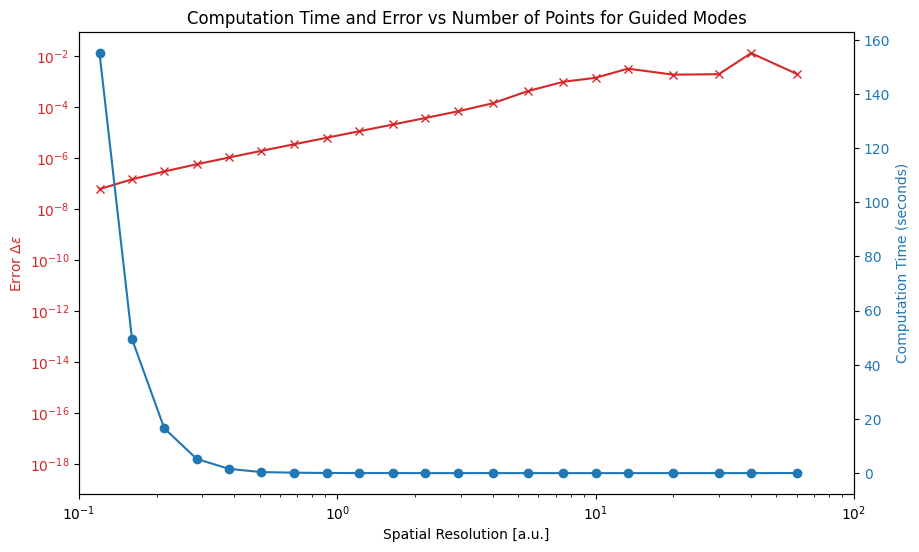

In [20]:
# Plotting computation time and error on the same plot with two y-axes
plt.figure(figsize=(10, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot error (left y-axis)
ax1.plot(spatial_resolutions_2d, error_2d, marker='x', color='tab:red', label='Effective Permittivity')
ax1.scatter(8000, 0, color='black', label='Reference Value', zorder=5, marker="x")
ax1.axhline(0, color='black', linestyle='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([10**(-1), 10**(2)])  # Set x-axis limits for better visibility
ax1.set_xlabel('Spatial Resolution [a.u.]')
ax1.set_ylabel(r'Error $\Delta\epsilon$', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
#ax1.legend(loc='lower right')

# Plot computation time (right y-axis)
ax2.plot(spatial_resolutions_2d, time_results_2d, marker='o', color='tab:blue', label='Computation Time')
#ax2.set_yscale('log')
ax2.set_ylabel('Computation Time (seconds)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
#ax2.legend(loc='lower right')

plt.title('Computation Time and Error vs Number of Points for Guided Modes')
plt.show()